In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
import rubin_sim
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline
rubin_sim.__version__

'1.3.2'

In [2]:
from os import path

opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
print(f"Using {run_name}, to be read from {opsim_fname}")
# TODO: update to v3.3
# opsim_fname is being pulled from a rubin_sim command - Heather is going to update this.

Using baseline_v2.1_10yrs, to be read from /global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db


In [14]:
# Plot wish-list:
# After cutting to extragalactic WFD area, we want the following:
#   - Distribution of i-band coadd M5 values (ExgalM5WithCuts - applies the cuts mentioned above) at each data release from year 1 - year 10 (DR2-DR11)
#   - Later we want all bands, not just i
#   - Is there something for coadded PSF size?  Need to check.  Unclear.  Definitely has things for individual exposures.
# We want to be able to compare across different axes:
#   - For a given strategy, compare distributions at various years.
#   - For a given year, compare distributions across strategies.
#   - for a given year and strategy, compare distributions across bands.
# Ultimately we might summarize these in terms of a std or some percentile range.

## Let's start with a simple metric bundle of only the coaddm5 metric
Remember that the list of metrics is here: https://rubin-sim.lsst.io/rs_maf/metric_list.html

In [20]:
# TODO: add cut to "extragalactic area"
# Can add different metrics etc. to this bundle
# Need to figure out how to get intermediate years rather than full 10 years (follow Lynne's example)
depth_map_bundle = maf.MetricBundle(
    metric=maf.Coaddm5Metric(),
    slicer=maf.HealpixSlicer(nside=64),
    constraint="filter='i'",
    run_name=run_name,
)

bgroup = maf.MetricBundleGroup(
    [depth_map_bundle], opsim_fname
)
bgroup.run_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


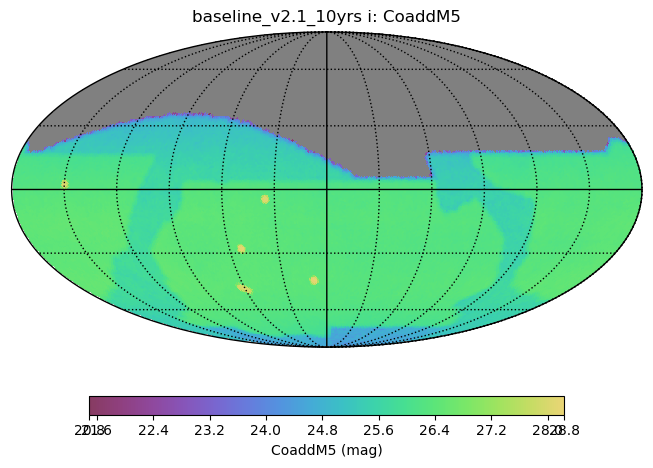

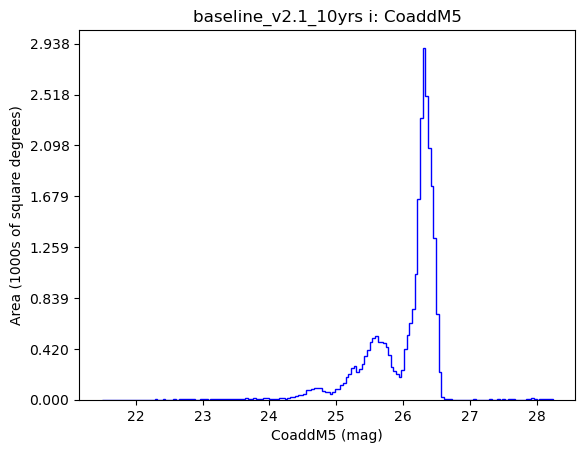

In [21]:
bgroup.plot_all(closefigs=False)

### What if we want to change the opsim we are using?
We define a new opsim file name and then regenerate the metric on this new opsim

In [9]:
# This lives in Renee's space and she has hacked permissions so the rest of us can read it.  
# But Heather is going to make these accessible in a more sound way.
new_opsim_fname = '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db'
new_run_name = 'No roll v3.3'
print(f"{new_run_name} will be read from {new_opsim_fname}")

# This is the same code as above, but `new_run_name` and `new_opsim_fname` are new.
# We can later turn this into a function that takes run name and opsim_fname as arguments.
newdepth_map_bundle = maf.MetricBundle(
    metric=maf.Coaddm5Metric(),
    slicer=maf.HealpixSlicer(nside=64),
    constraint="filter='i'",
    run_name=new_run_name,
)

newbgroup = maf.MetricBundleGroup(
    [newdepth_map_bundle], new_opsim_fname
)
newbgroup.run_all()

No roll v3.3 will be read from /pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


We don't see a lot of difference given that we are comparing the coadded m5 magnitude

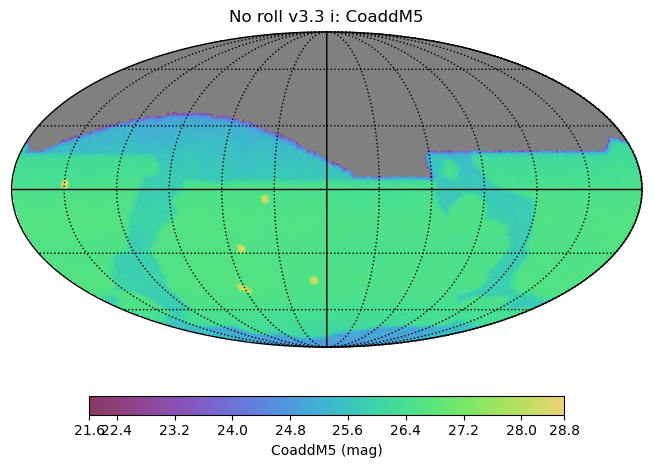

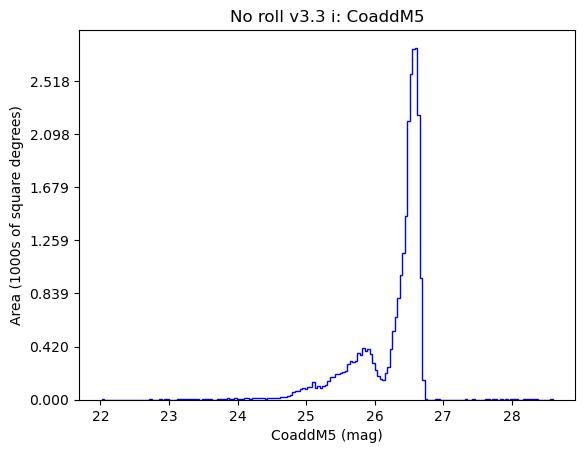

In [10]:
newbgroup.plot_all(closefigs=False)

## Now let's write a grouping over max fivesigma depth

Now we are going to use the 'OneDSlicer' to plot histograms explicitly

In [11]:
# 5-sigma depth is *per exposure*, not the coadd.
# We're back to the baseline, because it's using `run_name`
# Again, let's make it a function because we're gonna use this a bunch of times.
fivesigma_slice_bundle = {
    "g": maf.MetricBundle(
        metric=maf.CountMetric(col="fiveSigmaDepth"),
        slicer=maf.OneDSlicer(
            slice_col_name="fiveSigmaDepth", bin_min=20.0, bin_max=25.0, bin_size=0.05
        ),
        constraint="filter = 'g'",
        plot_dict={"color": "k"},
        run_name=run_name,
    ),
    "i": maf.MetricBundle(
        metric=maf.CountMetric(col="fiveSigmaDepth"),
        slicer=maf.OneDSlicer(
            slice_col_name="fiveSigmaDepth", bin_min=20.0, bin_max=27, bin_size=0.05
        ),
        constraint="filter = 'i'",
        plot_dict={"color": "g"},
        run_name=run_name,
    ),
}

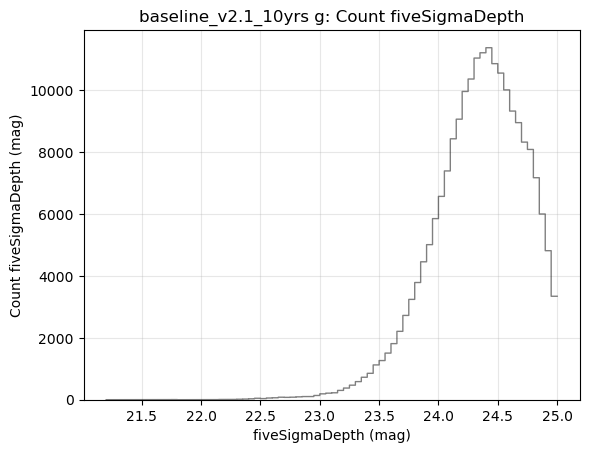

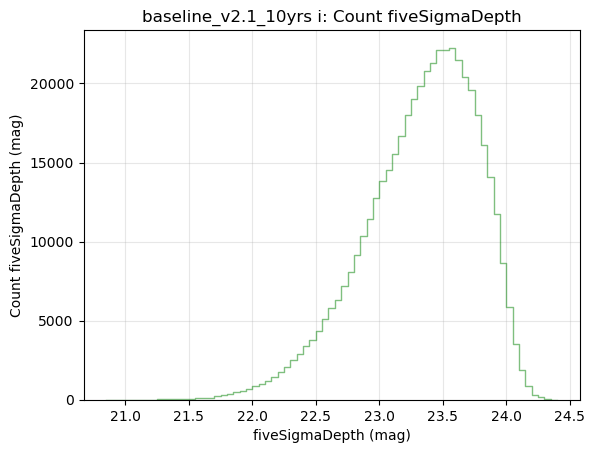

In [12]:
fivesigma_bg = maf.MetricBundleGroup(
    fivesigma_slice_bundle, opsim_fname
)
fivesigma_bg.run_all()
fivesigma_bg.plot_all(closefigs=False)

## And now regenerate the bundle with the new opsim

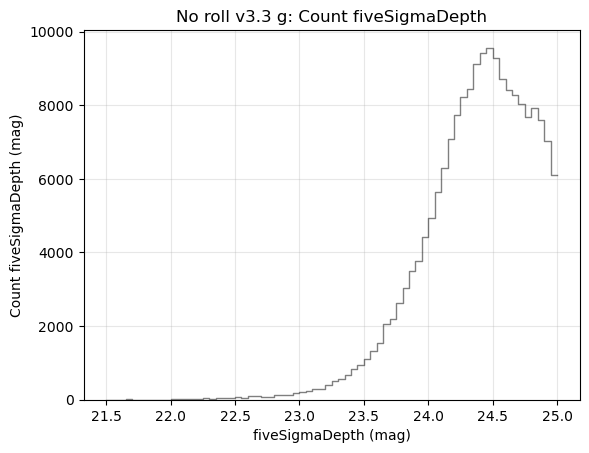

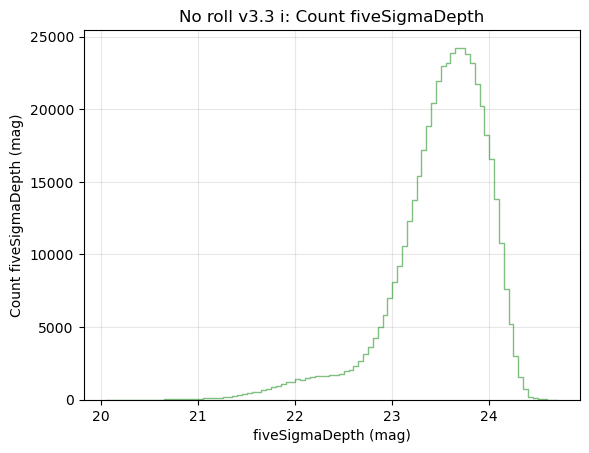

In [13]:
# Same as above except for run name and fname
fivesigma_slice_bundle2 = {
    "g": maf.MetricBundle(
        metric=maf.CountMetric(col="fiveSigmaDepth"),
        slicer=maf.OneDSlicer(
            slice_col_name="fiveSigmaDepth", bin_min=20.0, bin_max=25.0, bin_size=0.05
        ),
        constraint="filter = 'g'",
        plot_dict={"color": "k"},
        run_name=new_run_name,
    ),
    "i": maf.MetricBundle(
        metric=maf.CountMetric(col="fiveSigmaDepth"),
        slicer=maf.OneDSlicer(
            slice_col_name="fiveSigmaDepth", bin_min=20.0, bin_max=27, bin_size=0.05
        ),
        constraint="filter = 'i'",
        plot_dict={"color": "g"},
        run_name=new_run_name,
    ),
}

fivesigma_bg2 = maf.MetricBundleGroup(
    fivesigma_slice_bundle2, new_opsim_fname
)
fivesigma_bg2.run_all()
fivesigma_bg2.plot_all(closefigs=False)


In [15]:
example2_combine = maf.PlotHandler()

example2_combine.set_metric_bundles([fivesigma_slice_bundle, fivesigma_slice_bundle2])

plot_dicts = [
    {"label": run_name, "color": "k"},
    {"label": new_run_name, "color": "g"},
]

example2_combine.plot(plot_func=maf.OneDBinnedData(), plot_dicts=plot_dicts)

AttributeError: 'dict' object has no attribute 'file_root'